<a href="https://colab.research.google.com/github/lomovtsevp/ML_course_MIREA/blob/main/4/ML_LAB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize


# В данной лабораторной работе вам предлагается несколько моделей линейной регрессии и пронаблюдать эффект недообучения,
# переобучения, а так же пронаблюдать соответствующие этим случаям кривые обучения.

# Для выполнения данной лабораторной работы, необходимо заполнить код в следующих фукнциях:
# scale_features - стандартизирует признаки,
# compute_cost - вычисляет функцию стоимости,
# compute_cost_grad - вычисляет градиент фукнции стоимости,
# compute_learning_curves - вычисляет значения кривых обучения.

# Кроме заполнения этих функций настоятельно рекомендуется ознакомится с содержимым остальных функций.
# Комментарии к графикам:
# 1. Исходные данные
# 2. Обученная модель линейной регрессии.
#    Здесь можно наблюдать эффект недообучения модели из-за недостаточной сложности.
# 3. Кривые обучения для недообученной модели, изображенной на графике 2.
#    Можно заметить, что ошибка на всем обучающем наборе и на всем валидационном наборе велика - признак недообучения.
# 4. Обученная модель с полиномиальными признаками. На графике можно наблюдать, как функция проходит почти через
#    все точки обучающего набора (отмечены красными крестами).
# 5. Кривые обучения, соответствующие модели с полиномиальными признаками. Можно наблюдать большой разрыв между ошибкой
#    на всем обучающем наборе и на всем валидационном - признак переобучения.

In [232]:
def compute_hypothesis(X, theta):

    # Функция для вычисления гипотезы линейной регрессии.
    # Принимает на вход X - матрицу данных, theta - вектор параметров.
    # Возвращает вектор значений функции гипотезы на всех примерах из матрицы X.

    return X @ theta

In [233]:
def train_linear_regression(X_train, y_train, init_theta, lamb):

    # Функция для обучения алгоритма линейной регрессии.
    # Принимает на вход X_train - матрицу данных, y_train - вектор значений целевой переменной,
    # init_theta - вектор начальногог приблежения параметров для старта градиентного спуска,
    # lamb - параметр регуляризации.
    # Возвращает кортеж из двух элементов: флаг успеха минимизации (True или False) и оптимальный вектор параметров.

    opt_theta_obj = minimize(lambda th: compute_cost(X_train, y_train, th, lamb), init_theta,
                             method='BFGS',
                             jac=lambda th: compute_cost_grad(X_train, y_train, th, lamb),
                             options={'gtol': 1e-5, 'maxiter': 200, 'disp': False})
    return opt_theta_obj.success, opt_theta_obj.x

In [234]:
def show_learning_curves(curves):

    # Функция для отрисовки кривых обучения.
    # Принимает на вход список котрежей. Индекс кортежа - координата по оси абсцисс, элементы кортежа - значения
    # кривой обучения на обучающем наборе и валидационном наборе соответственно.

    tr_curve = list(map(lambda x: x[0], curves))
    val_curve = list(map(lambda x: x[1], curves))

    plt.plot(range(1, len(tr_curve) + 1), tr_curve)
    plt.plot(range(1, len(val_curve) + 1), val_curve)

    plt.xlim(2, len(curves) + 1)
    plt.ylim(0, 150)

    plt.title('Кривые обучения')

    plt.ylabel('Ошибка')
    plt.xlabel('Количество примеров в обучающем наборе')

    plt.legend(['Обучающий набор', 'Валидационный набор'])

    plt.show()

In [235]:
def map_features(X, p):

    # Функция для добавления степеней в набор признаков примера.
    # Принимает на вход X - матрицу данных, p - степень рещультирующего полинома.
    # Возвращает новую матрицу данных, в которую добавлены степени первого (X[:, 1]) признака матрицы данных
    # до p-ой включительно.

    for i in range(2, p + 1):
        X = np.append(X, X[:, 1].reshape(X.shape[0], 1) ** i, axis=1)
    return X

In [236]:
def load_data(data_file_path):

    # Функция для загрузки данных.
    # Принимает на вход путь к файлу.
    # На выход возвращает кортеж из двух элементов:
    # матрицу данных с фиктивным признаком и вектор значений целевой переменной.

    with open(data_file_path) as input_file:
        X = list()
        y = list()
        for line in input_file:
            *row, label = map(float, line.split(','))
            X.append([1] + row)
            y.append(label)
        return np.array(X, float), np.array(y, float)

In [237]:
def scale_features(X):

    # Функция для стандартизации признаков.
    # Принимает на вход матрицу данных X.
    # На выход возвращает кортеж из двух элементов: новую матрицу данных, со стандартизированными признаками и
    # кортеж из двух элементов: вектор средних значений признаков и вектор средних квадратических отклонений.

    result = np.zeros((X.shape[0], X.shape[1] - 1))  # матрица результата, её нужно заполнить.
    mean = np.zeros(X.shape[1] - 1)
    
    mean = np.mean(X[:, 1:], axis=0)   # вектор средних значений признаков, его нужно заполнить.
    std = np.std(X[:, 1:], axis=0)

    result = (X[:, 1:] - mean) / std


    return np.insert(result, 0, 1, axis=1), (mean, std)

In [238]:
def compute_cost(X, y, theta, lamb):

    # Функция для расчета стоимости (ошибки) модели на наборе данных.
    # Принимает на вход X - матрицу данных, y - вектор значений целевой переменной, theta - вектор параметров,
    # lamb - параметр регуляризации.
    # Возвращает значение функции стоимости на данном наборе данных.

    m, n = X.shape  # количество примеров в выборке и признаков в примере соответственно.
    cost = 1 / (2 * m) * np.sum((compute_hypothesis(X, theta) - y) ** 2) + (lamb / m) * np.sum(theta**2)  # значение функции стоимости, его нужно рассчитать.

    return cost

In [239]:
def compute_cost_grad(X, y, theta, lamb):

    # Функция для расчета градиента функции стоимости в заданной точке.
    # Принимает на вход X - матрицу данных, y - вектор значений целевой переменной,
    # theta - точка, в которой расчитывается градиент, lamb - параметр регуляризации.
    # Возвращает градиент функции стоимости в заданной точке.

    m, n = X.shape  # количество примеров в выборке и признаков в примере соответственно.
    grad = (1 / m) * ((compute_hypothesis(X, theta) - y).T @ X) + 2 * lamb / m * theta  # вектор градиента функции стоимости, его надо рассчитать.


    return grad

In [240]:
def compute_learning_curves(X_train, y_train, X_val, y_val, lamb):

    # Функция для расчета кривых обучения.
    # Принимает на вход X_train - матрицу данных обучющего набора,
    # y_train - вектор целевой переменной обучающего набора, X_val - матрицу данных валидационного набора,
    # y_val - вектор целевой переменной валидационного набора, lamb - параметр решуляризации.

    m, n = X_train.shape  # количество примеров в выборке и признаков в примере соответственно.
    result = list()  # список значений кривых обучения.
    init_theta = np.ones(X_val.shape[1])

    for i in range(1, m):


        train_error = 0  # значение функции стоимости на i примерах обучающего набора, его необходимо расчитать.
        val_error = 0  # значение функции стоимости на всем валидационном наборе, его необходимо расчитать.

        
        opt_theta = train_linear_regression(X_train[:i, :], y_train[:i], init_theta, init_lamb)[1]
        print(f'шаг {i}: веса: {opt_theta}')
        train_error = compute_cost(X_train, y_train, opt_theta, lamb)
        val_error = compute_cost(X_val, y_val, opt_theta, lamb)
        
    

        result.append((train_error, val_error))


    return result

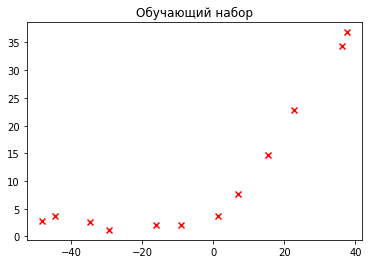

Значение функции стоимости при theta = [1, 1], lamb = 1.0 (должно быть ~303.993):  304.1181922202643
Значение градиента функции стоимости при theta = [1, 1], lamb = 1.0 (должно быть ~[-15.30, 598.25]):  [-15.13634901 598.33407751]

Обучение модели линейной регрессии..
Минимизация функции стоимости прошла успешно.


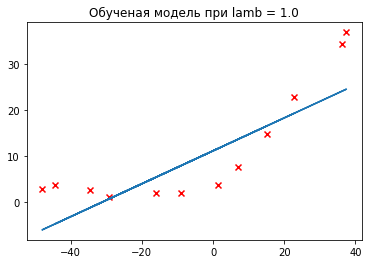

шаг 1: веса: [ 0.00830535 -0.13236032]
шаг 2: веса: [ 0.24340172 -0.05176254]
шаг 3: веса: [8.45481426 0.51767385]
шаг 4: веса: [9.57073769 0.59737711]
шаг 5: веса: [12.25131537  0.43384622]
шаг 6: веса: [11.48952078  0.4393611 ]
шаг 7: веса: [11.08677857  0.43021804]
шаг 8: веса: [11.60813476  0.40417357]
шаг 9: веса: [10.8150642   0.39783213]
шаг 10: веса: [11.36651763  0.35425928]
шаг 11: веса: [10.82866533  0.34508584]


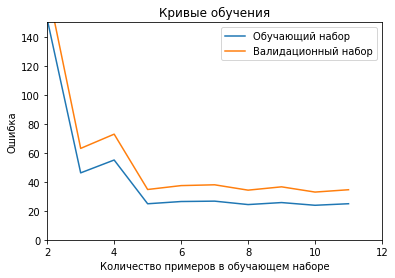


Обучение модели полномиальной регрессии..
Минимизация функции стоимости прошла успешно.


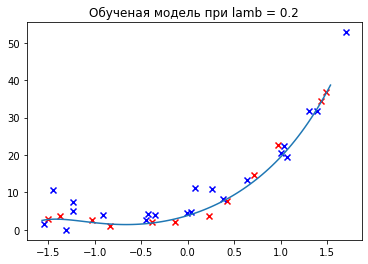

шаг 1: веса: [ 0.40728788 -0.15405407 -0.3212126   0.07751858 -0.30041199  0.13043475
 -0.25135836  0.14655644 -0.21630702]
шаг 2: веса: [ 0.45534428 -0.2100915  -0.29418897  0.04974042 -0.30331066  0.12752222
 -0.26770619  0.15620063 -0.23671598]
шаг 3: веса: [ 4.16233292  5.2113784   2.73334922  4.84154971  1.08827097  3.92238344
 -0.09400243  3.11613428 -0.78698374]
шаг 4: веса: [ 4.63155606  5.71306481  3.19986641  5.51474416  1.46001982  4.57562251
  0.14747062  3.67969409 -0.66249595]
шаг 5: веса: [7.3125567  5.05821045 4.44589703 4.78390573 3.0839766  3.36189103
 2.02910634 2.07948793 1.37148341]
шаг 6: веса: [7.51527817 5.07721382 4.23585388 4.79382873 3.02147798 3.33061807
 2.03130031 2.02898678 1.40482912]
шаг 7: веса: [8.47687391 6.33274591 3.4717968  4.36556249 2.49377328 2.76340623
 1.83089511 1.51966949 1.42698011]
шаг 8: веса: [8.72003174 6.03102823 3.83585402 4.1435941  2.57606458 2.77240534
 1.67969958 1.71819325 1.12674529]
шаг 9: веса: [8.61643913 5.98461872 3.978886

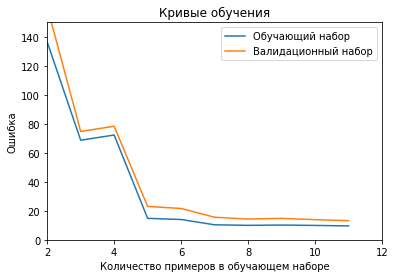


Оценка качества модели на тестовом наборе: 4.95294175296091


In [241]:
# Загрузка данных
X_train, y_train = load_data('lab4data1.txt')
X_val, y_val = load_data('lab4data2.txt')
X_test, y_test = load_data('lab4data3.txt')

plt.title('Обучающий набор')
plt.scatter(X_train[:, 1], y_train, c='r', marker='x')
plt.show()

init_theta = np.array([1, 1])
init_lamb = 1.0

print('Значение функции стоимости при theta = [1, 1], lamb = 1.0 (должно быть ~303.993): ',
      compute_cost(X_train, y_train, init_theta, init_lamb))

print('Значение градиента функции стоимости при theta = [1, 1], lamb = 1.0 (должно быть ~[-15.30, 598.25]): ',
      compute_cost_grad(X_train, y_train, init_theta, init_lamb))

print()
print('Обучение модели линейной регрессии..')

success, opt_theta = train_linear_regression(X_train, y_train, init_theta, init_lamb)
print('Минимизация функции стоимости ' + ('прошла успешно.' if success else 'не удалась.'))

plt.title('Обученая модель при lamb = 1.0')
plt.scatter(X_train[:, 1], y_train, c='r', marker='x')
plt.plot(X_train[:, 1], compute_hypothesis(X_train, opt_theta))
plt.show()

lin_learning_curves = compute_learning_curves(X_train, y_train, X_val, y_val, 0.0)
show_learning_curves(lin_learning_curves)

poly_pow = 8  # степень полинома для полиномиальной регрессии, можно варьировать
poly_lamb = 0.2  # параметр регуляризации для полиномиальной регрессии, можно варьировать

X_train_poly, (mean, std) = scale_features(map_features(X_train, poly_pow))
X_val_poly = scale_features(map_features(X_val, poly_pow))[0]

X_plot_poly = np.array([[i ** p for p in range(poly_pow + 1)] for i in range(-50, 40)], dtype=float)
X_plot_poly[:, 1:] = (X_plot_poly[:, 1:] - mean) / std

print()
print('Обучение модели полномиальной регрессии..')

success, opt_theta = train_linear_regression(X_train_poly, y_train, np.zeros(X_train_poly.shape[1]), poly_lamb)
print('Минимизация функции стоимости ' + ('прошла успешно.' if success else 'не удалась.'))

plt.title('Обученая модель при lamb = ' + str(poly_lamb))
plt.scatter(X_train_poly[:, 1], y_train, c='r', marker='x')
plt.scatter(X_val_poly[:, 1], y_val, c='b', marker='x')
plt.plot(X_plot_poly[:, 1], compute_hypothesis(X_plot_poly, opt_theta))
plt.show()

poly_learning_curves = compute_learning_curves(X_train_poly, y_train, X_val_poly, y_val, poly_lamb)
show_learning_curves(poly_learning_curves)

X_test = map_features(X_test, poly_pow)
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

print()
print('Оценка качества модели на тестовом наборе:', compute_cost(X_test, y_test, opt_theta, 0.0))